In [97]:
# !/usr/bin/python
# -*- coding: latin-1 -*-
# WAVELET LIBRARY - Based on Torrence and Combo (1998)
# author: Mabel Calim Costa
# GMAO - INPE
# 23/01/2013

import numpy as np
import pylab
from pylab import detrend_mean
import math

""" Translating mfiles of the Torrence and Combo to python functions
    1 - wavetest.m
    2 - wave_bases.m
    3 - wave_signif.m
    4 - chisquare_inv.m
    5 - chisquare_solve.m
"""


def nextpow2(i):
    n = 2
    while n < i:
        n = n * 2
    return n


def wave_bases(mother, k, scale, param):
    """Computes the wavelet function as a function of Fourier frequency
    used for the CWT in Fourier space (Torrence and Compo, 1998)
    -- This def is called automatically by def wavelet --

    _____________________________________________________________________
    Inputs:
    mother - a string equal to 'Morlet'
    k      - a vectorm the Fourier frequecies
    scale  - a number, the wavelet scale
    param  - the nondimensional parameter for the wavelet function

    Outputs:
    daughter       - a vector, the wavelet function
    fourier_factor - the ratio os Fourier period to scale
    coi            - a number, the cone-of-influence size at the scale
    dofmin         - a number, degrees of freedom for each point in the
                     wavelet power (Morlet = 2)

    Call function:
    daughter,fourier_factor,coi,dofmin = wave_bases(mother,k,scale,param)
    _____________________________________________________________________
    """
    n = len(k)  # length of Fourier frequencies (came from wavelet.py)
    """CAUTION : default values"""
    if (mother == 'Morlet'):  # choose the wavelet function
        param = 6  # For Morlet this is k0 (wavenumber) default is 6
        k0 = param
        # table 1 Torrence and Compo (1998)
        expnt = -pow(scale * k - k0, 2) / 2 * (k > 0)
        norm = math.sqrt(scale * k[1]) * \
            (pow(math.pi, -0.25)) * math.sqrt(len(k))
        daughter = []  # define daughter as a list

        for ex in expnt:  # for each value scale (equal to next pow of 2)
            daughter.append(norm * math.exp(ex))
        k = np.array(k)  # turn k to array
        daughter = np.array(daughter)  # transform in array
        daughter = daughter * (k > 0)  # Heaviside step function
        # scale --> Fourier
        fourier_factor = (4 * math.pi) / (k0 + math.sqrt(2 + k0 * k0))
        # cone-of- influence
        coi = fourier_factor / math.sqrt(2)
        dofmin = 2  # degrees of freedom
# ---------------------------------------------------------#
    elif (mother == 'DOG'):
        param = 2
        m = param
        expnt = -pow(scale * k, 2) / 2.0
        pws = (pow(scale * k, m))
        pws = np.array(pws)
        """CAUTION gamma(m+0.5) = 1.3293"""
        norm = math.sqrt(scale * k[1] / 1.3293) * math.sqrt(n)
        daughter = []
        for ex in expnt:
            daughter.append(-norm * pow(1j, m) * math.exp(ex))
        daughter = np.array(daughter)
        daughter = daughter[:] * pws
        fourier_factor = (2 * math.pi) / math.sqrt(m + 0.5)
        coi = fourier_factor / math.sqrt(2)
        dofmin = 1
# ---------------------------------------------------------#
    elif (mother == 'PAUL'):  # Paul Wavelet
        param = 4
        m = param
        k = np.array(k)
        expnt = -(scale * k) * (k > 0)
        norm = math.sqrt(scale * k[1]) * \
        (2 ** m / math.sqrt(m * \
                            (math.factorial(2 * m - 1)))) * math.sqrt(n)
        pws = (pow(scale * k, m))
        pws = np.array(pws)
        daughter = []
        for ex in expnt:
            daughter.append(norm * math.exp(ex))
        daughter = np.array(daughter)
        daughter = daughter[:] * pws
        daughter = daughter * (k > 0)     # Heaviside step function
        fourier_factor = 4 * math.pi / (2 * m + 1)
        coi = fourier_factor * math.sqrt(2)
        dofmin = 2
    else:
        print ('Mother must be one of MORLET,PAUL,DOG')

    return daughter, fourier_factor, coi, dofmin


def wavelet(Y, dt, param, dj, s0, j1, mother):
    """Computes the wavelet continuous transform of the vector Y,
       by definition:

    W(a,b) = sum(f(t)*psi[a,b](t) dt)        a dilate/contract
    psi[a,b](t) = 1/sqrt(a) psi(t-b/a)       b displace

    Only Morlet wavelet (k0=6) is used
    The wavelet basis is normalized to have total energy = 1 at all scales

    _____________________________________________________________________
    Input:
    Y - time series
    dt - sampling rate
    mother - the mother wavelet function
    param - the mother wavelet parameter

    Output:
    ondaleta - wavelet bases at scale 10 dt
    wave - wavelet transform of Y
    period - the vector of "Fourier"periods ( in time units) that correspond
             to the scales
    scale - the vector of scale indices, given by S0*2(j*DJ), j =0 ...J1
    coi - cone of influence

    Call function:
    ondaleta, wave, period, scale, coi = wavelet(Y,dt,mother,param)
    _____________________________________________________________________

    """

    n1 = len(Y)  # time series length
    #s0 = 2 * dt  # smallest scale of the wavelet
    # dj = 0.25  # spacing between discrete scales
    # J1 = int(np.floor((np.log10(n1*dt/s0))/np.log10(2)/dj))
    J1 = int(np.floor(np.log2(n1 * dt / s0) / dj))  # J1+1 total os scales
    # print 'Nr of Scales:', J1
    # J1= 60
    # pad if necessary
    x = detrend_mean(Y)  # extract the mean of time series
    pad = 1
    if (pad == 1):
        base2 = nextpow2(n1)  # call det nextpow2
    n = base2
    """CAUTION"""
    # construct wavenumber array used in transform
    # simetric eqn 5
    #k = np.arange(n / 2)
    
    import math
    k_pos, k_neg = [], []
    for i in arange(0, int(n / 2) ):
        k_pos.append(i * ((2 * math.pi) / (n * dt)))  # frequencies as in eqn5
        k_neg = k_pos[::-1]  # inversion vector
        k_neg = [e * (-1) for e in k_neg]  # negative part
        # delete the first value of k_neg = last value of k_pos
        #k_neg = k_neg[1:-1]
    print(len(k_neg),len(k_pos))    
    k = np.concatenate((k_pos, k_neg), axis=0)  # vector of symmetric
    # compute fft of the padded time series
    f = np.fft.fft(x, n)
    scale = []
    for i in range(J1 + 1):
        scale.append(s0 * pow(2, (i) * dj))

    period = scale
    # print period
    wave = np.zeros((J1 + 1, n))  # define wavelet array
    wave = wave + 1j * wave  # make it complex
    # loop through scales and compute transform
    for a1 in range(J1 + 1):
        daughter, fourier_factor, coi, dofmin = wave_bases(
            mother, k, scale[a1], param)  # call wave_bases
        wave[a1, :] = np.fft.ifft(f * daughter)  # wavelet transform
        if a1 == 11:
            ondaleta = daughter
    # ondaleta = daughter
    period = np.array(period)
    period = period[:] * fourier_factor

    # cone-of-influence, differ for uneven len of timeseries:
    if (((n1) / 2.0).is_integer()) is True:
        # create mirrored array)
        mat = np.concatenate(
            (arange(1, int(n1 / 2)), arange(1, int(n1 / 2))[::-1]), axis=0)
        # insert zero at the begining of the array
        mat = np.insert(mat, 0, 0)
        mat = np.append(mat, 0)  # insert zero at the end of the array
    elif (((n1) / 2.0).is_integer()) is False:
        # create mirrored array
        mat = np.concatenate(
            (arange(1, int(n1 / 2) + 1), arange(1, int(n1 / 2))[::-1]), axis=0)
        # insert zero at the begining of the array
        mat = np.insert(mat, 0, 0)
        mat = np.append(mat, 0)  # insert zero at the end of the array
    coi = [coi * dt * m for m in mat]  # create coi matrix
    # problem with first and last entry in coi added next to lines because 
    # log2 of zero is not defined and cannot be plottet later:
    coi[0] = 0.1  # coi[0] is normally 0
    coi[len(coi)-1] = 0.1 # coi[last entry] is normally 0 too
    wave = wave[:, 0:n1]
    return ondaleta, wave, period, scale, coi, f


def wave_signif(Y, dt, scale1, sigtest, lag1, sig1v1, dof, mother, param):
    """CAUTION : default values"""
    import scipy
    from scipy import stats

    n1 = np.size(Y)
    J1 = len(scale1) - 1
    s0 = np.min(scale1)
    dj = np.log10(scale1[1] / scale1[0]) / np.log10(2)
    """CAUTION"""
    if (n1 == 1):
        variance = Y
    else:
        variance = np.var(Y)
    """CAUTION"""
    # sig1v1 = 0.95
    if (mother == 'Morlet'):
        # get the appropriate parameters [see table2]
        param = 6
        k0 = param
        fourier_factor = float(4 * math.pi) / (k0 + np.sqrt(2 + k0 * k0))
        empir = [2, -1, -1, -1]
        if(k0 == 6):
            empir[1:4] = [0.776, 2.32, 0.6]

    if(mother == 'DOG'):
        param = 2
        k0 = param
        m = param
        fourier_factor = float(2 * math.pi / (np.sqrt(m + 0.5)))
        empir = [1, -1, -1, -1]
        if(k0 == 2):
            empir[1:4] = [3.541, 1.43, 1.4]

    if (mother == 'PAUL'):
        param = 4
        m = param
        fourier_factor = float(4 * math.pi / (2 * m + 1))
        empir = [2., -1, -1, -1]
        if (m == 4):
            empir[1:4] = [1.132, 1.17, 1.5]

    period = [e * fourier_factor for e in scale1]
    dofmin = empir[0]  # Degrees of  freedom with no smoothing
    Cdelta = empir[1]  # reconstruction factor
    gamma_fac = empir[2]  # time-decorrelation factor
    dj0 = empir[3]  # scale-decorrelation factor
    freq = [dt / p for p in period]
    fft_theor = [((1 - lag1 * lag1) / (1 - 2 * lag1 *
                                       np.cos(f * 2 * math.pi) + lag1 * lag1))
                 for f in freq]
    fft_theor = [variance * ft for ft in fft_theor]
    signif = fft_theor
    if(dof == -1):
        dof = dofmin
    """CAUTION"""
    if(sigtest == 0):
        dof = dofmin
        chisquare = scipy.special.gammaincinv(dof / 2.0, sig1v1) * 2.0 / dof
        signif = [ft * chisquare for ft in fft_theor]
    elif (sigtest == 1):
        """CAUTION: if len(dof) ==1"""
        dof = np.array(dof)
        truncate = np.where(dof < 1)
        dof[truncate] = np.ones(np.size(truncate))
        for i in range(len(scale1)):
            dof[i] = (
                dofmin * np.sqrt(1 + pow((dof[i] * dt / gamma_fac / scale1[i]),
                                         2)))
        dof = np.array(dof)  # has to be an array to use np.where
        truncate = np.where(dof < dofmin)
        # minimum DOF is dofmin
        dof[truncate] = [dofmin * n for n in np.ones(len(truncate))]
        chisquare, signif = [], []
        for a1 in range(J1 + 1):
            chisquare.append(
                scipy.special.gammaincinv(dof[a1] / 2.0, sig1v1) * 2.0 /
                dof[a1])
            signif.append(fft_theor[a1] * chisquare[a1])
    """CAUTION : missing elif(sigtest ==2)"""
    return signif, fft_theor


In [108]:
# !/usr/bin/python
# -*- coding: latin-1 -*-
# WAVELET Torrence and Combo translate from Matlab to Python
# author: Mabel Calim Costa
# INPE
# 23/01/2013

"Baseado : Torrence e Combo"

# data from http://paos.colorado.edu/research/wavelets/software.html

import numpy as np
import pylab
from pylab import *
import matplotlib.pyplot as plt
import os
import sys
import netCDF4


def load_nc(file, var, dt, date1):
    """
    OPEN ARCHIVE .NC
    file = archive.nc
    var  = variable from archive.nc
    dt   = data sampling
    date1= data intial time
    """

    f = netCDF4.Dataset(file, 'r+')
    data = f.variables[var][:]
    n = len(data)
    time = np.arange(n) * dt + date1
    f.close()
    return data, time


def load_txt(archive, dt, date1):
    """
    OPEN ARCHIVE .TXT/.DAT
    archive = file.txt
    dt      = data sampling
    date1   = data initial time
    """

    filename = os.path.join(sys.prefix, 'lib', 'python' + sys.version[
                            :3], 'site-packages', 'wavelet', 'lib',
                            'wavelet', 'data', 'txt', archive)
    if(not os.path.isfile(filename) and os.path.isfile(archive)):
        filename = archive
    else:
        raise IOError(
            'File {0} not found either here {1} or here {1}'.format(filename,
                                                                    archive))
    data = np.loadtxt(filename)
    n = len(data)
    time = np.arange(n) * dt + date1
    return data, time


def normalize(data):
    """
    NORMALIZE FUNCTION by - mean/sqrt(variance)
    """
    variance = np.var(data)
    data = (data - np.mean(data)) / (np.sqrt(variance))
    return data


def cwt(data, dt, pad, dj, s0, j1, lag1, param, mother, name):
    """
    CONTINUOUS WAVELET TRANSFORM
    pad = 1         # pad the time series with zeroes (recommended)
    dj = 0.25       # this will do 4 sub-octaves per octave
    s0 = 2*dt       # this says start at a scale of 6 months
    j1 = 7/dj       # this says do 7 powers-of-two with dj sub-octaves each
    lag1 = 0.72     # lag-1 autocorrelation for red noise background
    param = 6
    mother = 'Morlet'
    """

    #from cwt.lib_wavelet import wavelet,wave_signif

    variance = np.var(data)
    n = len(data)
    # Wavelet transform
    ondaleta, wave, period, scale, coi, f = wavelet(
        data, dt, param, dj, s0, j1, mother)
    # wave = np.array(wave)
    power = (np.abs(wave) ** 2)
    # Significance levels: (variance=1 for the normalized SST)
    signif, fft_theor = wave_signif(
        1.0, dt, scale, 0, lag1, 0.95, -1, mother, param)
    ones = np.ones((len(signif), n))  # expand signif --> ones (J+1)x(n)
    sig95 = [s * ones[1] for s in signif]   # vstack signif concatenate
    sig95 = power / sig95  # where ratio > 1, power is significant
    # Global wavelet spectrum & significance levels:
    global_ws = variance * (np.sum(power.conj().transpose(), axis=0) / n)
    dof = [n - s for s in scale]
    """CAUTION - DEFAULT VALUES """
    global_signif, fft_theor = wave_signif(
        variance, dt, scale, 1, lag1, 0.95, dof, mother, param)
    # Daughter wavelet

    joint_wavelet = np.concatenate((np.fft.ifft(ondaleta)[int(np.ceil(
        n / 2.)):], np.fft.ifft(ondaleta)[int(np.ceil(n / 2.)):][::-1]), axis=0)
    imag_wavelet = np.concatenate((np.fft.ifft(ondaleta).imag[int(np.ceil(
        n / 2.)):], np.fft.ifft(ondaleta).imag[int(np.ceil(n / 2.)):][::-1]), axis=0)
    nw = np.size(joint_wavelet)  # daughter's number of points
    # admissibility condition
    mean_wavelet = mean(joint_wavelet.real)
    mean_wavelet = np.ones(nw) * mean_wavelet
    result = {'ondaleta': ondaleta, 'wave': wave, 'period': period,
              'scale': scale, 'coi': coi, 'power': power, 'sig95': sig95,
              'global_ws': global_ws, 'global_signif': global_signif,
              'joint_wavelet': joint_wavelet, 'imag_wavelet': imag_wavelet,
              'nw': nw, 'mean_wavelet': mean_wavelet, 'dj': dj, 'j1': j1,
              'dt': dt, 'fft': f, 'mother': mother, 'data': data, 'name': name}
    return result

# result = cwt(data_norm,0.25,1,0.25,2*0.25,7/0.25,0.72,6,'Morlet')


def fft(data):
    """FFT spectrum
    """
    n = len(data)
    X = np.fft.fft(data)
    sxx = ((X * np.conj(X)) / (n))
    f = -np.fft.fftfreq(n)[int(np.ceil(n / 2.)):]
    sxx = np.abs(sxx)
    sxx = sxx[int(np.ceil(n / 2.)):]
    return f, sxx

# ---------------------------
#           Ploting
# ---------------------------


def levels(result, dtmin):
    """
    Power levels
    """

    dtmax = result['power'].max()
    lev = []
    for i in range(int(log2(dtmax / dtmin))):
        dtmin = dtmin * 2
        lev.append(dtmin)
    return lev


def wavelet_plot(var, time, data, dtmin, result):
    """
    PLOT WAVELET TRANSFORM
    var = title name from data
    time  = vector get in load function
    data  = from normalize function
    dtmin = minimum resolution :1 octave
    result = dict from cwt function
    """

    from numpy import log2
    import numpy as np
    #import wavetest
    import matplotlib
    import matplotlib.gridspec as gridspec

    # frequency limit
    # print result['period']
    # lim = np.where(result['period'] == result['period'][-1]/2)[0][0]
    """Plot time series """

    fig = plt.figure(figsize=(15, 10), dpi=300)

    gs1 = gridspec.GridSpec(4, 3)
    gs1.update(left=0.05, right=0.7, wspace=0.5, hspace=0)
    ax1 = plt.subplot(gs1[0, :])
    ax1 = pylab.gca()
    ax1.xaxis.set_visible(False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax2 = plt.subplot(gs1[1:4, :])#, axisbg='#C0C0C0')

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=0.7, right=0.98, hspace=0)
    ax5 = plt.subplot(gs2[1:4, 0], sharey=ax2)
    plt.setp(ax5.get_yticklabels(), visible=False)

    gs3 = gridspec.GridSpec(6, 1)
    gs3.update(left=0.77, top=0.86, right=0.98, hspace=0.6, wspace=0.01)
    ax3 = plt.subplot(gs3[0, 0])

    # ----------------------------------------------------------------------------------------------------------------#
    ax1.plot(time, data)
    ax1.axis('tight')
    ax1.set_ylabel('SP [mV]', fontsize=15)
    ax1.set_title('%s' % var, fontsize=17)
    ax1.yaxis.set_major_locator(MaxNLocator(prune='lower'))
    ax1.grid(True)
    ax1.xaxis.set_visible(False)
    # ----------------------------------------------------------------------------------------------------------------#
    ax3.plot(arange(-result['nw'] / 2, result['nw'] / 2),result['joint_wavelet'], 'k', label='Real part')
    ax3.plot(arange(-result['nw'] / 2, result['nw'] / 2),result['imag_wavelet'], '--k', label='Imag part')
    ax3.plot(arange(-result['nw'] / 2, result['nw'] / 2),result['mean_wavelet'], 'g', label='Mean')
    # ax3.axis('tight')
    ax3.set_xlim(-40, 40)
    # ax3.set_ylim(-0.3,0.3)
    # ax3.set_ylim([np.min(result['joint_wavelet']),np.max(result['joint_wavelet'])])
    ax3.set_xlabel('Time', fontsize=10)
    ax3.set_ylabel('Amplitude', fontsize=10)
    ax3.set_title('$\psi$ (t/s) {0} in time domain'.format(result['mother']))
    # ----------------------------------------------------------------------------------------------------------------#
    # ax4.plot(result['ondaleta'],'k')
    # ax4.set_xlabel('Frequency', fontsize=10)
    # ax4.set_ylabel('Amplitude', fontsize=10)
    # ax4.set_title('$\psi^-$  Frequency domain', fontsize=13)
    # ----------------------------------------------------------------------------------------------------------------#
    """ Contour plot wavelet power spectrum """
    lev = levels(result, dtmin)
    pc = ax2.contourf(time, np.log2(result['period']),np.log2(result['power']), np.log2(lev))
    # 95% significance contour, levels at -99 (fake) and 1 (95% signif)
    pc2 = ax2.contour(time, np.log2(result['period']), result['sig95'],[-99, 1], linewidths=2)
    ax2.plot(time, np.log2(result['coi']), 'k')
    # cone-of-influence , anything "below"is dubious
    ax2.fill_between(time, np.log2(result['coi']), int(np.log2(result['period'][-1]) + 1), alpha=0.5, hatch='/')
    position = fig.add_axes([0.07, 0.07, 0.6, 0.01])
    cbar = plt.colorbar(pc, cax=position, orientation='horizontal')
    cbar.set_label('Power')
    yt = range(int(np.log2(result['period'][0])), int(np.log2(result['period'][-1]) + 1))  # create the vector of periods
    Yticks = [float(math.pow(2, p)) for p in yt]  # make 2^periods
    # Yticks = [int(i) for i in Yticks]
    ax2.set_yticks(yt)
    ax2.set_yticklabels(Yticks)
    ax2.set_ylim(ymin=(np.log2(np.min(result['period']))), ymax=(np.log2(np.max(result['period']))))
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Period', fontsize=12)
    ax2.axhline(y=10.5, xmin=0, xmax=1, linewidth=2, color='k')
    ax2.axhline(y=13.3, xmin=0, xmax=1, linewidth=2, color='k')
    # ----------------------------------------------------------------------------------------------------------------#
    """ Plot global wavelet spectrum """
    f, sxx = fft(data)
    ax5.plot(sxx, np.log2(1 / f * result['dt']), 'gray', label='Fourier spectrum')
    ax5.plot(result['global_ws'], np.log2(result['period']), 'b', label='Wavelet spectrum')
    ax5.plot(result['global_signif'], np.log2(result['period']), 'r--', label='95% confidence spectrum')
    ax5.legend(loc=0)
    ax5.set_xlim(0, 1.25 * np.max(result['global_ws']))
    ax5.set_xlabel('Power', fontsize=10)
    ax5.set_title('Global Wavelet Spectrum', fontsize=12)
    # save fig
    plt.savefig('%s.png' % var, dpi=300)


In [104]:
import numpy as np
from pylab import *
z = np.linspace(0,2048,2048)
x = np.sin(50*np.pi*z)
y = np.cos(50*np.pi*z)
data_norm = normalize(x)
result = cwt(data_norm, 1, 1, 0.125, 2, 4/0.125, 0.72, 6,mother='Morlet',name='x')

1024 1024


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


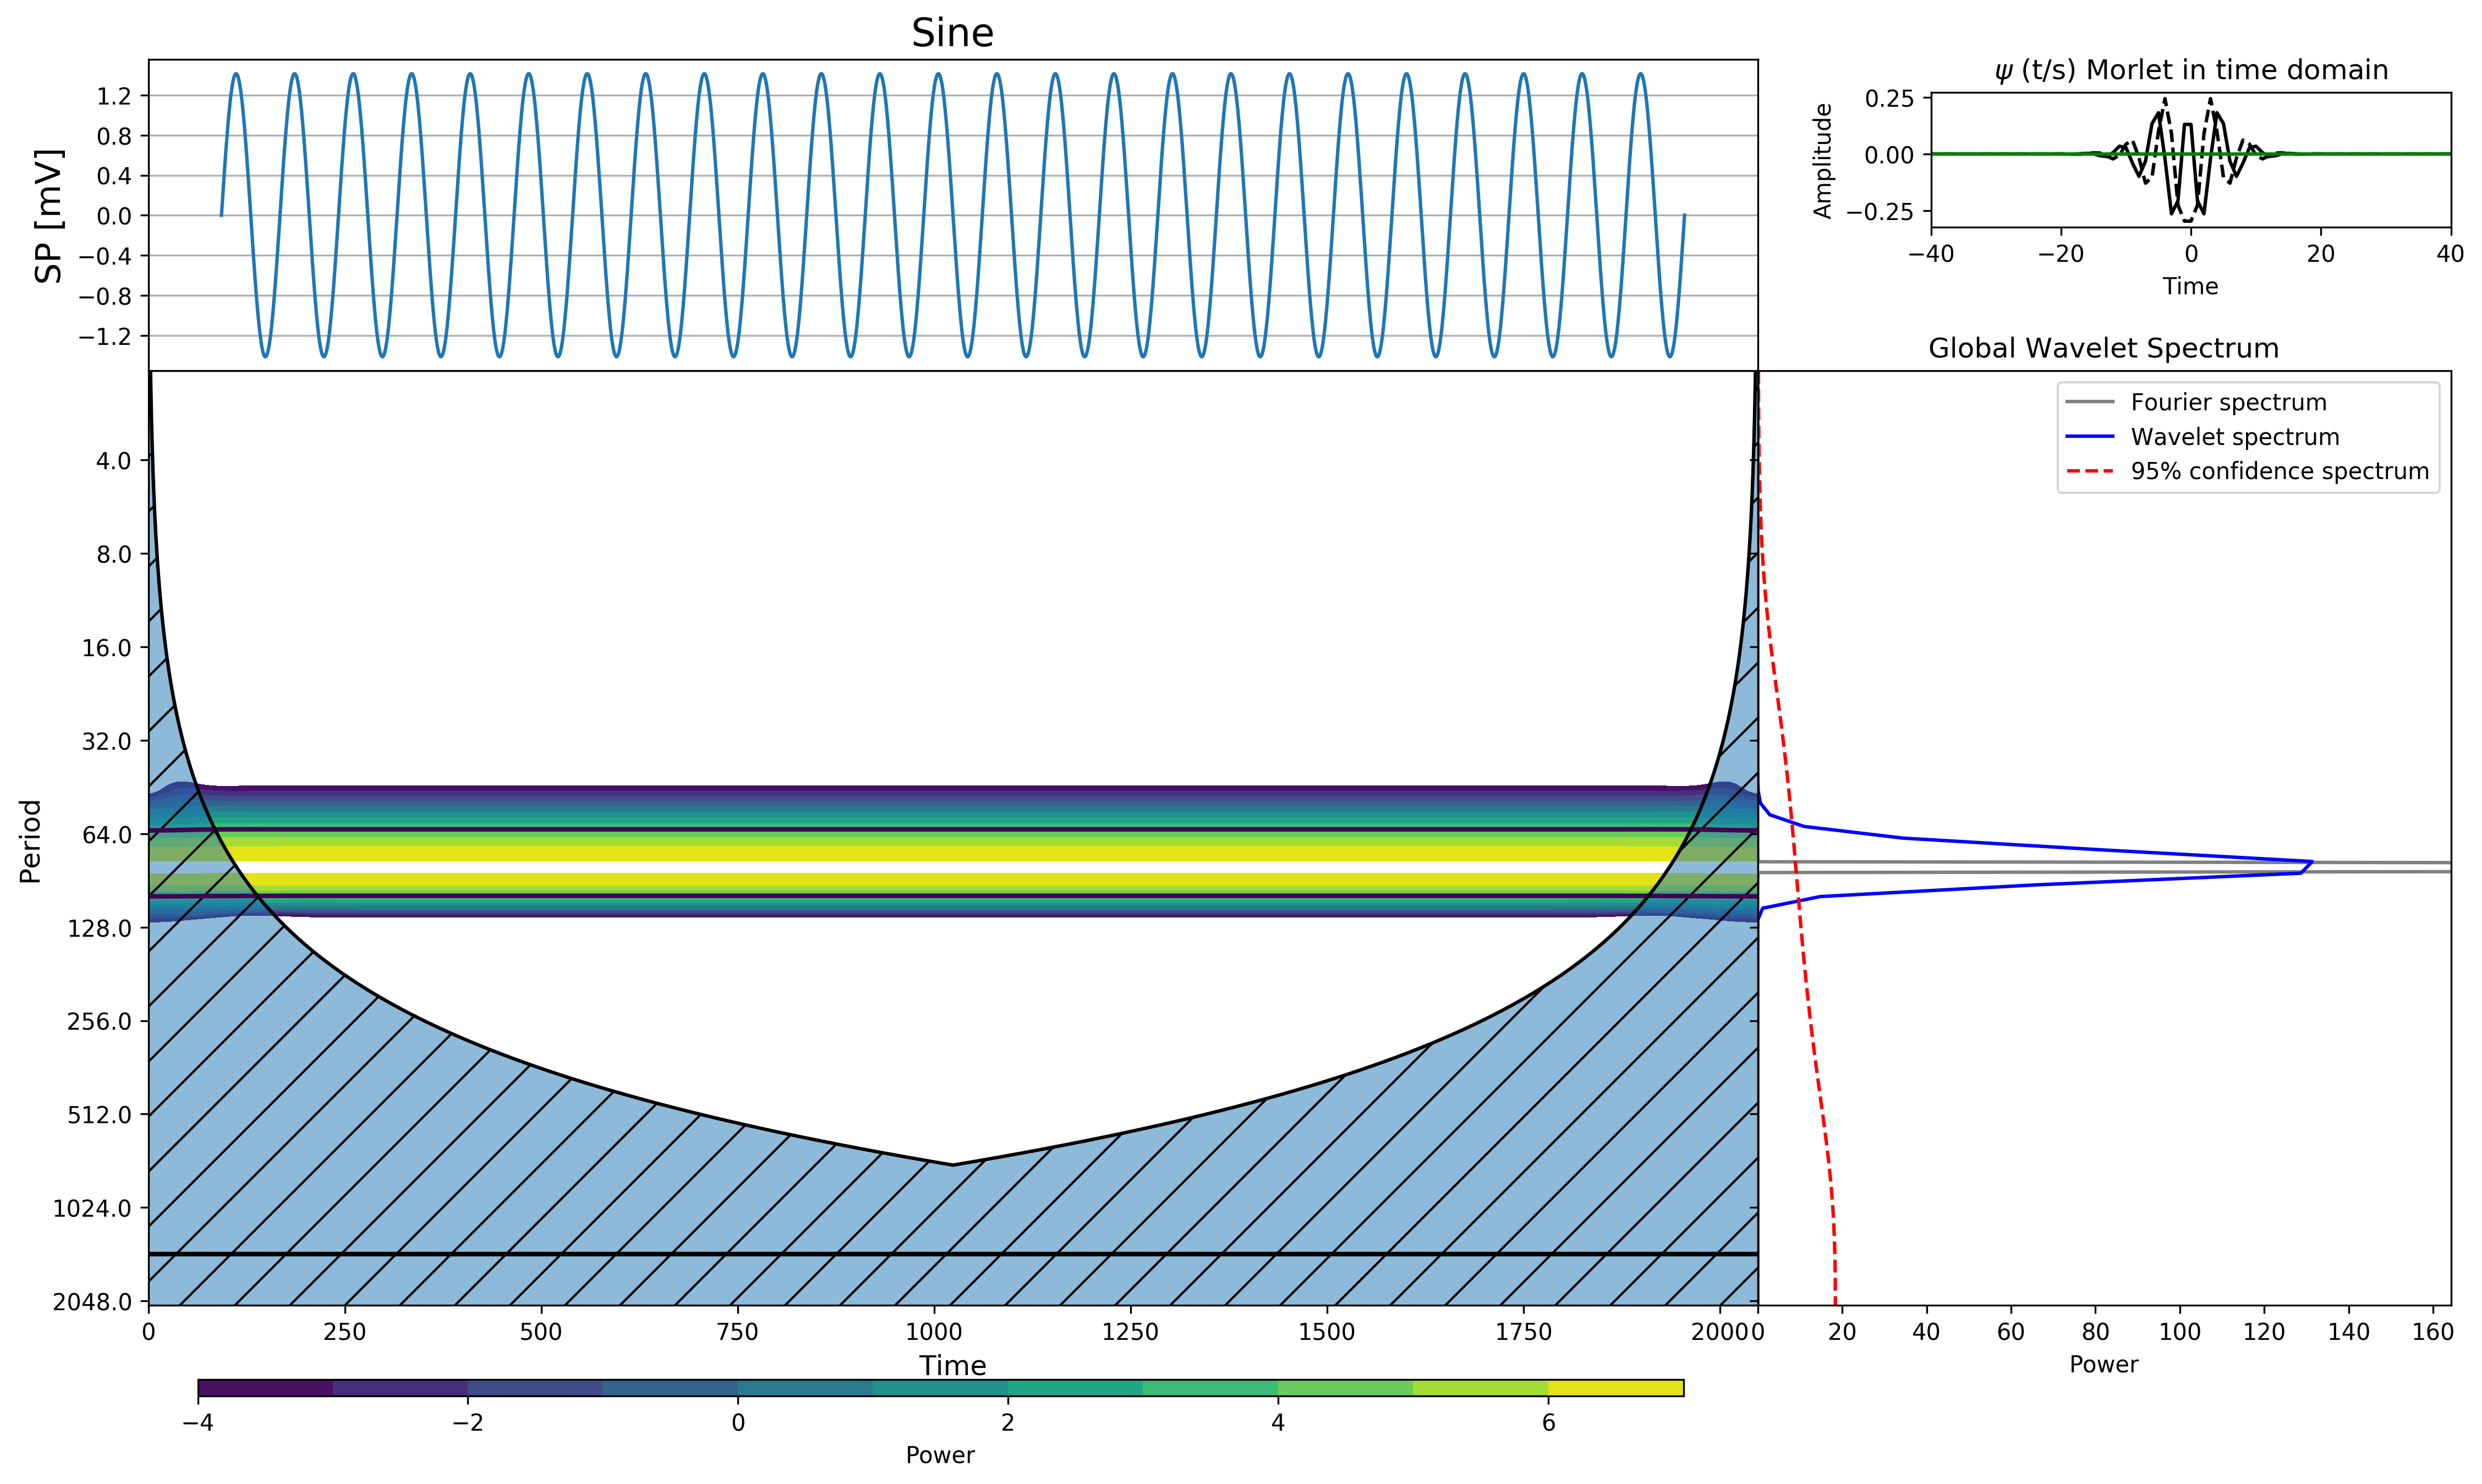

In [109]:
wavelet_plot('Sine', z, data_norm, 0.03125, result)